## Weak dependence results

In [2]:
import numpy as np
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from localization import datasets
from localization import models
from localization import samplers
from localization.experiments import simulate_or_load, simulate, make_key
from localization.utils import ipr, plot_receptive_fields, plot_rf_evolution, build_gaussian_covariance, build_non_gaussian_covariance, entropy_sort, build_DRT
from scipy.special import erf
from tqdm import tqdm
import itertools

In [3]:
config = dict(
  seed=0,#42, #0,
  num_dimensions=40, 
  dim=1,
  adjust=(-1.0, 1.0),
  class_proportion=0.5,
  # Model
  num_hiddens=1,
  init_scale=0.001,
  activation='relu',
  model_cls=models.SimpleNet,
  use_bias=False, bias_trainable=False, bias_value=0.0,
  optimizer_fn=optax.sgd, 
  learning_rate=0.05,
  num_steps=2000, num_epochs=2000,
  sampler_cls=samplers.EpochSampler,
  init_fn=models.xavier_normal_init,
  loss_fn='mse',
  save_=True,
  evaluation_interval=10, # 100
  # Misc
  supervise=True,
  wandb_=False, 
)

### Ising Model

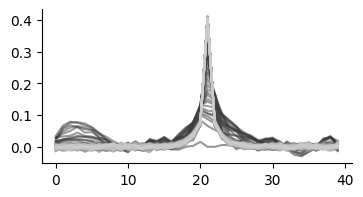

In [5]:
# weights_ising, metrics = simulate_or_load(dataset_cls=datasets.IsingDataset, xi=(0.3, 0.7,), batch_size=500, **config)
fig, ax = plot_rf_evolution(-weights_ising[:,[0],:], figsize=(4, 2)) # Just flipping sign so it looks more visually appealing
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig('fig3/rf_evol/ising.pdf', bbox_inches='tight')

IsingDataset[-1.00,01.00]_xi1=00.70_xi2=00.30_p=0.50_batch_size=500_num_epochs=2000_loss=mse_lr=0.050_SimpleNetnobias_L=040_K=001_activation=relu_init_scale=0.001_xavier_normal_init_seed=42
IsingDataset[-1.00,01.00]_xi1=00.70_xi2=00.30_p=0.50_batch_size=500_num_epochs=2000_loss=mse_lr=0.050_SimpleNetnobias_L=040_K=001_activation=relu_init_scale=0.001_xavier_normal_init
File IsingDataset[-1.00,01.00]_xi1=00.70_xi2=00.30_p=0.50_batch_size=500_num_epochs=2000_loss=mse_lr=0.050_SimpleNetnobias_L=040_K=001_activation=relu_init_scale=0.001_xavier_normal_init.npz not found
Simulating
Using JAX backend: cpu

Using configuration:
{'activation': 'relu',
 'adjust': (-1.0, 1.0),
 'base_dataset': <class 'localization.datasets.nonlinear_gp.NonlinearGPDataset'>,
 'batch_size': 500,
 'bias_trainable': False,
 'bias_value': 0.0,
 'class_proportion': 0.5,
 'dataset_cls': <class 'localization.datasets.ising.IsingDataset'>,
 'df': None,
 'dim': 1,
 'evaluation_interval': 10,
 'gain': None,
 'init_fn': <fu

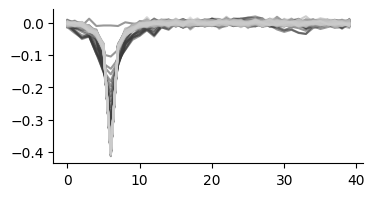

In [20]:
# weights_ising, metrics = simulate_or_load(dataset_cls=datasets.IsingDataset, xi=(0.3, 0.7,), batch_size=500, **config)
fig, ax = plot_rf_evolution(-weights_ising[:,[0],:], figsize=(4, 2)) # Just flipping sign so it looks more visually appealing
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig('fig3/rf_evol/ising.pdf', bbox_inches='tight')

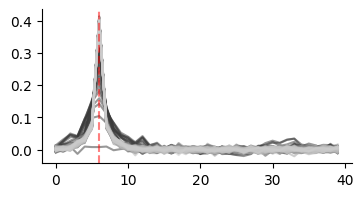

In [35]:
fig, ax = plot_rf_evolution(weights_ising[:,[0],:], figsize=(4, 2)) # Just flipping sign so it looks more visually appealing
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axvline(6, color='r', linestyle='--', alpha=0.5)
fig.savefig('fig3/rf_evol/ising.pdf', bbox_inches='tight')

21


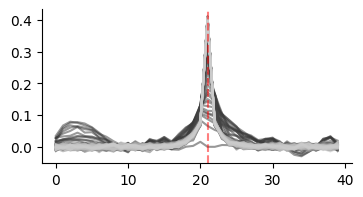

In [22]:
print(jnp.argmax(-weights_ising[-1,0]))
fig, ax = plot_rf_evolution(-weights_ising[:,[0],:], figsize=(4, 2)) # Just flipping sign so it looks more visually appealing
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axvline(21, color='r', linestyle='--', alpha=0.5)
fig.savefig('fig3/rf_evol/ising.pdf', bbox_inches='tight')

### Gaussian

In [27]:
weights_gaussian, metrics = simulate_or_load(dataset_cls=datasets.NonlinearGPDataset, gain=0.01, xi=(1, 3,), batch_size=10000, **config)
fig, ax = plot_rf_evolution(weights_gaussian[:,[0],:], figsize=(4, 2))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig('fig3/rf_evol/gaussian.pdf', bbox_inches='tight')

NonlinearGPDataset[-1.00,01.00]_xi1=03.00_xi2=01.00_gain=0.010_p=0.50_batch_size=10000_num_epochs=2000_loss=mse_lr=0.050_SimpleNetnobias_L=040_K=001_activation=relu_init_scale=0.001_xavier_normal_init_seed=0
Already simulated
Error in callback <function flush_figures at 0x156318c20> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

### Alg(5)

Approximate standard deviation: 0.6950598719782084
NortaDataset[-1.00,01.00]_xi1=03.00_xi2=01.00AlgQDF5_p=0.50_batch_size=10000_num_epochs=2000_loss=mse_lr=0.050_SimpleNetnobias_L=040_K=001_activation=relu_init_scale=0.001_xavier_normal_init_seed=0
Already simulated


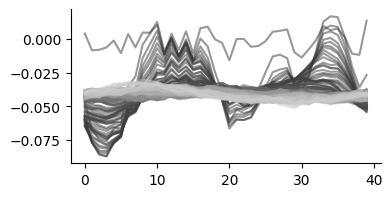

In [ ]:
weights_alg, metrics = simulate_or_load(dataset_cls=datasets.NortaDataset, marginal_qdf=datasets.AlgQDF(k=5), xi=(1, 3,), batch_size=10000, **config)
fig, ax = plot_rf_evolution(weights_alg[:,[0],:], figsize=(4, 2))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig('fig3/rf_evol/alg5.pdf', bbox_inches='tight')

## Loading data

In [6]:
data_config = dict(
    key=jax.random.PRNGKey(0),
    num_dimensions=40, 
    dim=1,
    num_exemplars=10000,
    adjust=(-1.0, 1.0),
    class_proportion=0.5,
)

In [7]:
dataset = datasets.IsingDataset(xi=(0.3, 0.7), **data_config)
x_ising, y_ising = dataset[:100000]
x = x_ising.flatten()
print(jnp.mean(x**4) / (jnp.var(x)**2)) # kurtosis

dataset = datasets.NonlinearGPDataset(gain=0.01, xi=(1, 3), **data_config)
x_gaussian, y_gaussian = dataset[:100000]
x = x_gaussian.flatten()
print(jnp.mean(x**4) / (jnp.var(x)**2)) # kurtosis

dataset = datasets.NortaDataset(marginal_qdf=datasets.AlgQDF(k=5), xi=(1, 3), **data_config)
x_alg, y_alg = dataset[:100000]
x = x_alg.flatten()
print(jnp.mean(x**4) / (jnp.var(x)**2)) # kurtosis

1.0000011280029544
2.991618799293822
Approximate standard deviation: 0.6950598719782084
3.8639321856227955


In [10]:
print( jnp.mean(y_ising == 0) )
print( jnp.mean(y_gaussian == 0) )
print( jnp.mean(y_alg == 0) )

0.50091
0.50091
0.50091


### Marginals

In [16]:
for model, x in zip(['ising', 'gaussian', 'alg5'], [x_ising, x_gaussian, x_alg]):

    r = (-1.5,1.5) if model == 'ising' else (-5,5)
    
    x = x.flatten()
    hist, bins = np.histogram(x, bins=100, range=r, density=False)
    hist = hist / hist.sum()

    fig, ax = plt.subplots(figsize=(4,2))

    # Plot the line
    bin_width = bins[1] - bins[0]
    ax.bar(bins[:-1], hist, width=bin_width, align='edge', color='#00356b')

    # Save
    fig.savefig(f'fig3/marginals/{model}.pdf', bbox_inches='tight')
    plt.close(fig)

### Computing $\varphi$, kurtosis

In [11]:
a = jnp.linspace(-1, 1, 100)
alginv = lambda x: x / jnp.sqrt(1 - x**2)
def varphi(a, x):
    a = a.reshape(1,-1)
    x = x.reshape(-1,1)
    return jnp.mean(x * erf( x / jnp.sqrt(2) * alginv (a) ), axis=0)

In [18]:
for model, x in zip(['ising', 'gaussian', 'alg5'], [x_ising, x_gaussian, x_alg]):

    x = x.flatten() # same as taking first entry, but we get more data
    y = varphi(a, x=x)
    kurtosis = jnp.mean(x**4) / (jnp.var(x)**2)
    print(kurtosis)
    
    # Taylor approx
    y_taylor = jnp.sqrt(2/jnp.pi) * ( a - (kurtosis - 3) / 6 * a**3 )

    fig, ax = plt.subplots(figsize=(4,2))

    # Plot the line
    ax.plot(a, y, color='black')
    ax.plot(a, y_taylor, color='red')

    ax.set_xticks([-1, -0.5, 0.5, 1])
    ax.set_yticks([-1, -0.5, 0.5, 1])

    # Remove the top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Set the position of the left and bottom spines to the zero of the data coordinate
    ax.spines['left'].set_position(('data', 0))
    ax.spines['bottom'].set_position(('data', 0))

    # Add ticks on the left and bottom spines only
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    # Draw lines at x=0 and y=0
    ax.axhline(0, color='black', linewidth=0.5)
    ax.axvline(0, color='black', linewidth=0.5)

    # Draw sqrt(2/pi) * x
    ax.axline((0,0), slope=jnp.sqrt(2/jnp.pi), linestyle=(0, (5, 5)), color='black', alpha=0.5)

    # Add text
    textstr = r'$\kappa = {:.2f}$'.format(kurtosis)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

    # Save
    fig.savefig(f'fig3/varphi/{model}.pdf', bbox_inches='tight')
    plt.close(fig)
    
    break

1.0000011280029544
2.991618799293822
3.8639321856227955


### Numerically integrate

In [12]:
tau = 0.05
num_steps = 2000
w_init = weights_ising[0,0]

In [13]:
from tqdm import tqdm
from functools import partial
alginv = lambda x: x / jnp.sqrt(1 - x**2)
def varphi(a, x):
    x = x.reshape(-1,1)
    a = a.reshape(1,-1)
    return jnp.mean(x * erf( x / jnp.sqrt(2) * alginv (a) ), axis=0)

In [14]:
def simulate_varphi(varphi, w_init, Sigma0, Sigma1, tau, num_steps):

    num_dimensions = len(w_init)
    w = jnp.zeros((num_steps, num_dimensions))
    w = w.at[0].set(w_init)

    for i in tqdm(range(1, num_steps)):
        sw1 = Sigma1 @ w[i-1]
        sw0 = Sigma0 @ w[i-1]
        a = sw1 / jnp.sqrt(sw1 @ w[i-1])
        f = varphi(a)
        w = w.at[i].set( w[i-1] + tau * (f - (sw0 + sw1) / 2) )
        
    return w

def simulate_kurtosis(kurtosis, w_init, Sigma0, Sigma1, tau, num_steps):

    num_dimensions = len(w_init)
    w = jnp.zeros((num_steps, num_dimensions))
    w = w.at[0].set(w_init)
    f = lambda x: jnp.sqrt(2/jnp.pi) * x + ((3 - kurtosis) / 6) * (x**3)

    for i in tqdm(range(1, num_steps)):
        sw1 = Sigma1 @ w[i-1]
        sw0 = Sigma0 @ w[i-1]
        a = sw1 / jnp.sqrt(sw1 @ w[i-1])
        w = w.at[i].set( w[i-1] + tau * (f(a) - (sw0 + sw1) / 2) )
        
    return w

ising


100%|██████████| 1999/1999 [00:07<00:00, 281.56it/s]


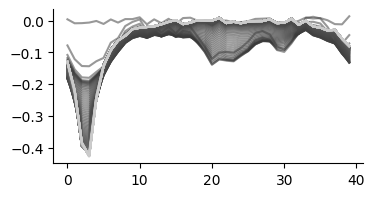

In [15]:
for model, (x, y) in zip(['ising', 'gaussian', 'alg5'], 
                                 [(x_ising, y_ising), 
                                  (x_gaussian, y_gaussian), 
                                  (x_alg, y_alg)]):
    
    print(model)
    
    # Compute class covariance matrices
    Sigma0 = np.cov(x[y==0].T)
    Sigma1 = np.cov(x[y==1].T)
    
    # # Integrate with full varphi
    # varphi_ = partial(varphi, x=x)
    # w_varphi = simulate_varphi(varphi_, w_init, Sigma0, Sigma1, tau, num_steps)
    # fig, ax = plot_rf_evolution(w_varphi[::10,[0],:], figsize=(4, 2))
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    # fig.savefig(f'fig3/rf_sim/{model}_varphi.pdf', bbox_inches='tight')
        
    # Integrate with just kurtosis term
    x = x.flatten()
    kurtosis = jnp.mean(x**4) / (jnp.var(x)**2)
    w_kurtosis = simulate_kurtosis(kurtosis, w_init, Sigma0, Sigma1, tau, num_steps)
    fig, ax = plot_rf_evolution(w_kurtosis.reshape(-1,1,40)[::10], figsize=(4, 2))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    fig.savefig(f'fig3/rf_sim/{model}_kurtosis.pdf', bbox_inches='tight')
    
    break

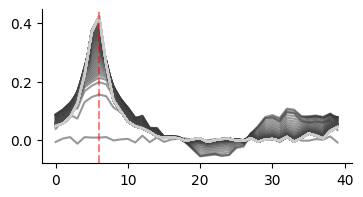

In [32]:
fig, ax = plot_rf_evolution(w_kurtosis.reshape(-1,1,40)[::10], figsize=(4, 2))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axvline(x=6, color='red', linestyle='--', alpha=0.5)
fig.savefig(f'fig3/rf_sim/{model}_kurtosis.pdf', bbox_inches='tight')

In [29]:
# jnp.argmax(w_kurtosis[-1])

Array(6, dtype=int64)

Array(3, dtype=int64)

3


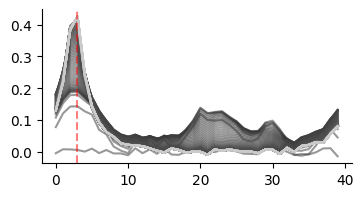

In [20]:
print(jnp.argmax(-w_kurtosis[-1]))
fig, ax = plot_rf_evolution(-w_kurtosis.reshape(-1,1,40)[::10], figsize=(4, 2))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axvline(x=3, color='red', linestyle='--', alpha=0.5)
fig.savefig(f'fig3/rf_sim/{model}_kurtosis.pdf', bbox_inches='tight')

In [ ]:
print(jnp.argmax(-w_kurtosis[-1]))
fig, ax = plot_rf_evolution(-weights_ising.reshape(-1,1,40)[::10], figsize=(4, 2))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axvline(x=3, color='red', linestyle='--', alpha=0.5)
fig.savefig(f'fig3/rf_evol/{model}_kurtosis.pdf', bbox_inches='tight')

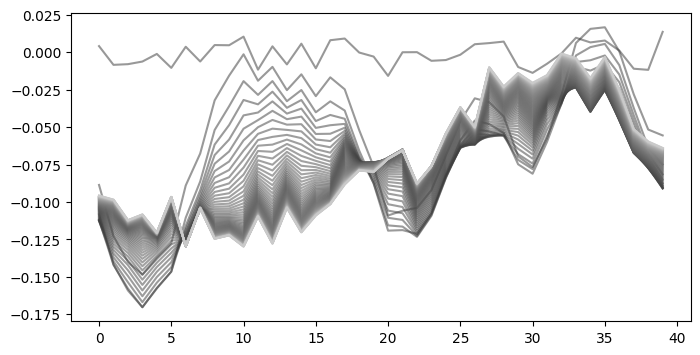

In [47]:
fig, axs = plot_rf_evolution(w_varphi[::10].reshape(-1,1,40), figsize=(8,4))

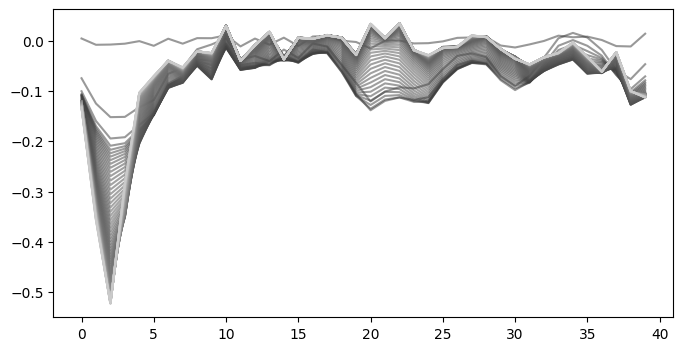

In [ ]:
fig, axs = plot_rf_evolution(w_kurtosis[::10].reshape(-1,1,40), figsize=(8,4))

### Kurtosis vs. IPR